# Logistic Regression

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from matplotlib.backends.backend_pdf import PdfPages

In [5]:
alldata = pd.read_csv('/home/wangmk/UM/Research/SURE/cleaned_data/full_cleaned_data.csv')
alldata = alldata.loc[alldata['First_toggle_time']!=10000,]

In [6]:
alldata.head()

,Trial,True_state,Alert,Identification,First_toggle_time,RMS,Attention,Click,Top_Left_Enemy,Top_Right_Enemy,Bottom_Left_Enemy,Bottom_Right_Enemy,Top_Left_Dark,Top_Right_Dark,Bottom_Left_Dark,Bottom_Right_Dark
0,0,True,True,True,4179,65.244487,0.914573,2,True,False,False,False,False,True,True,True
1,1,False,False,False,3653,67.293907,0.895000,2,False,False,False,False,True,True,True,True
2,2,False,True,False,2186,100.119892,0.854271,2,False,False,False,False,True,False,True,False
3,3,False,False,False,3412,33.403009,0.889447,2,False,False,False,False,True,False,True,True
4,4,False,False,False,4514,70.063858,0.929648,2,False,False,False,False,True,True,True,True


In [7]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3850 entries, 0 to 3999
Data columns (total 16 columns):
Trial                 3850 non-null int64
True_state            3850 non-null bool
Alert                 3850 non-null bool
Identification        3850 non-null bool
First_toggle_time     3850 non-null int64
RMS                   3850 non-null float64
Attention             3850 non-null float64
Click                 3850 non-null int64
Top_Left_Enemy        3850 non-null bool
Top_Right_Enemy       3850 non-null bool
Bottom_Left_Enemy     3850 non-null bool
Bottom_Right_Enemy    3850 non-null bool
Top_Left_Dark         3850 non-null bool
Top_Right_Dark        3850 non-null bool
Bottom_Left_Dark      3850 non-null bool
Bottom_Right_Dark     3850 non-null bool
dtypes: bool(11), float64(2), int64(3)
memory usage: 221.8 KB


In [8]:
abnormal = alldata[alldata['RMS']>60.5]
normal = alldata[alldata['RMS']<=60.5]

In [9]:
abnormal.shape

(157, 16)

Next We try logistic regression, the first and the most simple machine learning model for binary outcomes.

In [51]:
accuracy = []
precision = []
recall = []
auc = []
coefficients = pd.DataFrame(columns = alldata.drop(['RMS'],axis=1).columns)

In [52]:
coefficients.head()

,Trial,True_state,Alert,Identification,First_toggle_time,Attention,Click,Top_Left_Enemy,Top_Right_Enemy,Bottom_Left_Enemy,Bottom_Right_Enemy,Top_Left_Dark,Top_Right_Dark,Bottom_Left_Dark,Bottom_Right_Dark


In [53]:
for seed in range(10):
    print(seed)
    newdata = abnormal.append(normal.sample(n=157,random_state=seed))
    newdata['performance'] = newdata['RMS'] <= 60.5
    #newdata['First_toggle_time'] = newdata['First_toggle_time']/10000
    #newdata['Trial'] = newdata['Trial']/100
    X = newdata.drop(['RMS','performance'],axis=1)
    y = newdata['performance']
    allcolumns = X.columns
    for state in np.arange(20,30):
        print(state)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=state,stratify=y)
        X_train_new = X_train.copy()
        X_test_new = X_test.copy()
        for column in allcolumns:
            X_test_new.loc[:,column] = (X_test[column]-np.mean(X_train[column]))/np.std(X_train[column])
            X_train_new.loc[:,column] = (X_train[column]-np.mean(X_train[column]))/np.std(X_train[column])
        logreg = LogisticRegression('l1')
        searcher = GridSearchCV(logreg, {'C':[0.001, 0.01, 0.1, 1, 10,100]})
        searcher.fit(X_train_new, y_train)
        coefficients.loc[str(seed)+str(state),] = searcher.best_estimator_.coef_
        y_pred = searcher.predict(X_test_new)
        outcome = pd.DataFrame({'Real':y_test, 'Predicted':y_pred})
        precision.append(np.sum(outcome['Real'] & outcome['Predicted'])/np.sum(outcome['Predicted']))
        recall.append(np.sum(outcome['Real'] & outcome['Predicted'])/np.sum(outcome['Real']))
        accuracy.append(np.sum(y_pred==y_test)/len(y_pred))
        y_pred_prob = searcher.predict_proba(X_test_new)[:,1]
        auc.append(roc_auc_score(y_test,y_pred_prob))

0
20
21
22
23
24
25
26
27
28
29
1
20
21
22
23
24
25
26
27
28
29
2
20
21
22
23
24
25
26
27
28
29
3
20
21
22
23
24
25
26
27
28
29
4
20
21
22
23
24
25
26
27
28
29
5
20
21
22
23
24
25
26
27
28
29
6
20
21
22
23
24
25
26
27
28
29
7
20
21
22
23
24
25
26
27
28
29
8
20
21
22
23
24
25
26
27
28
29
9
20
21
22
23
24
25
26
27
28
29


In [34]:
coefficients.head()

,Trial,True_state,Alert,Identification,First_toggle_time,Attention,Click,Top_Left_Enemy,Top_Right_Enemy,Bottom_Left_Enemy,Bottom_Right_Enemy,Top_Left_Dark,Top_Right_Dark,Bottom_Left_Dark,Bottom_Right_Dark
200,0.331852,0.0,0.000000,0.247777,-0.166883,1.747946,0.812473,-0.401913,0.059954,0.109264,-0.217204,0.0,-0.039548,0.049618,-0.065122
201,0.191325,0.0,0.000000,0.000000,0.000000,0.990601,0.459269,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
202,0.234811,0.0,0.000000,0.000000,0.000000,0.908885,0.358584,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
203,0.102370,0.0,-0.002446,0.000000,0.000000,0.995933,0.397554,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
204,0.196002,0.0,0.000000,0.000000,0.000000,1.008731,0.444316,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000


In [35]:
conclusion = pd.DataFrame(coefficients.apply(np.mean),columns=['Coefficients'])

In [36]:
print("Average accuracy is: ",np.mean(accuracy))
print("Median accuracy is: ",np.median(accuracy))
print("Average precision is: ",np.mean(precision))
print("Median precision is: ",np.median(precision))
print("Average recall is: ",np.mean(recall))
print("Median recall is: ",np.median(recall))
print("Average auc is: ",np.mean(auc))
print("Median auc is: ",np.median(auc))

Average accuracy is:  0.7847368421052632
Median accuracy is:  0.7894736842105263
Average precision is:  0.7729503637851038
Median precision is:  0.774547554871005
Average recall is:  0.808665780141844
Median recall is:  0.8105053191489362
Average auc is:  0.8608665780141842
Median auc is:  0.8583776595744681


In [37]:
np.min(auc)

0.7686170212765957

In [38]:
import pickle

In [39]:
outcome = {'accuracy':accuracy,'precision':precision,'recall':recall,'auc':auc}
with open('outcome_logreg_1.pkl','wb+') as f:
    pickle.dump(outcome,f)

In [40]:
coefficients.to_csv('/home/wangmk/UM/Research/SURE/cleaned_data/coefficients_logreg_1.csv')

In [41]:
conclusion.sort_values('Coefficients')

,Coefficients
Top_Left_Enemy,-0.094155
Bottom_Right_Dark,-0.038018
Bottom_Right_Enemy,-0.022604
Top_Left_Dark,-0.016129
Alert,-0.012978
First_toggle_time,-0.007690
True_state,-0.007518
Top_Right_Enemy,0.009386
Bottom_Left_Dark,0.056443
Top_Right_Dark,0.076913


In [54]:
from scipy.stats import ttest_1samp

In [55]:
def ttest1(var):
    tstats, _ = ttest_1samp(var,0)
    return np.abs(tstats)

In [56]:
def ttest2(var):
    _, pval = ttest_1samp(var,0)
    return pval

In [57]:
Tstats= pd.DataFrame(coefficients.apply(ttest1),columns=['T statistic'])

In [58]:
Pvals = pd.DataFrame(coefficients.apply(ttest2),columns=['P Value'])

In [59]:
Pvals.sort_values('P Value')

,P Value
Attention,2.029622e-58
Click,1.011845e-47
Trial,6.229010e-38
Bottom_Left_Enemy,4.925127e-14
Top_Left_Enemy,3.206313e-13
Bottom_Left_Dark,3.560707e-11
Identification,1.050216e-08
Alert,3.060939e-06
Bottom_Right_Enemy,7.645379e-06
First_toggle_time,3.768410e-05


In [60]:
Tstats.sort_values('T statistic',ascending=False)

,T statistic
Attention,35.765414
Click,27.190283
Trial,20.810822
Bottom_Left_Enemy,8.782253
Top_Left_Enemy,8.406482
Bottom_Left_Dark,7.449085
Identification,6.247893
Alert,4.949141
Bottom_Right_Enemy,4.723931
First_toggle_time,4.316160


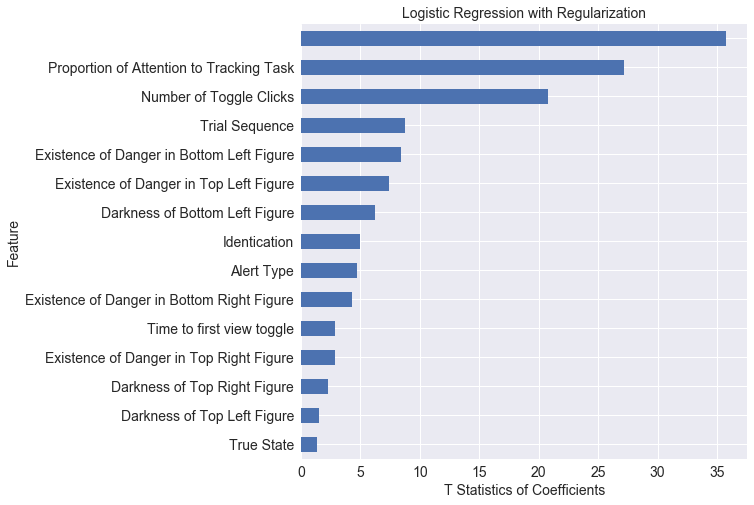

In [61]:
sns.set()
# create dataframe with top 10 by variable importance
df= Tstats.sort_values(by = 'T statistic', ascending = True)
labs = ['Proportion of Attention to Tracking Task','Number of Toggle Clicks','Trial Sequence',"Existence of Danger in Bottom Left Figure"
        ,"Existence of Danger in Top Left Figure",'Darkness of Bottom Left Figure',
        'Identication',"Alert Type", "Existence of Danger in Bottom Right Figure",'Time to first view toggle',
        "Existence of Danger in Top Right Figure","Darkness of Top Right Figure","Darkness of Top Left Figure",
        "True State"]
labs.reverse()
# plot
fig = plt.figure()
df.plot.barh(fontsize = 14,figsize = (8,8),legend=None).set_yticklabels(labs, rotation=0)
plt.xlabel('T Statistics of Coefficients',fontsize = 14)
plt.ylabel('Feature',fontsize = 14)
plt.title('Logistic Regression with Regularization',fontsize = 14)
plt.savefig("logreg.png",bbox_inches='tight')